In [ ]:
#!jupyter nbconvert --to=python Nutrients_depth_python3.ipynb

In [9]:
class Nut_depth:   
    '''
    class Nut_depth(runname,resultpath,savepath,meshpath,obspath,first_year,last_year,
                 mapproj='pc',savefig=False,depth_array=[0,100,6000])
                 
    c.f. Danilov et al. (2017):
    "in the vertical direction, the horizontal velocities and scalars are located at mid-levels" 
                 
    depth_array=[0,100,6000] describes ranges for plotting.
    1. subplot in range [0,1]
    2. subplot in range [0,2]
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,obspath,first_year,last_year,
                 mapproj='pc',
                 savefig=False,
                 depth_array=[0,100,6000],
                 latminmax=[-90,90]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.obspath = obspath
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.savefig = savefig
        self.depth_array = depth_array
        self.latminmax = latminmax

        import matplotlib.pyplot as plt
        import numpy as np
        from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf
 
        # give the latitudes which you want to make annual mean
        latmin,latmax = self.latminmax[0], self.latminmax[1]
        title = self.runname + ': Latitudes between  '+ str(latmin) + ' and ' + str(latmax)
        
        years = range(self.fyear, self.lyear+1)
        
        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh = pf.load_mesh(meshpath)
        level_depths = -mesh.zlev[:-1] # depth of levels
        #print(depths)
        #print(np.shape(level_depths))
        
        # load FESOM diag: layer depth and nodal area -------------------------------------------------------------------------------------
        meshdiag=resultpath+'/'+runname+'.mesh.diag.nc'
        #!ncdump -h $meshdiag
        diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=self.runname)   
        
        layer_depths = -diag['Z'].values # depth of layers
        # c.f. Danilov et al. (2017)
        # "in the vertical direction, the horizontal velocities and scalars are located at mid-levels" 
        #print(layer_depths) 
        layer_depths = layer_depths[:-1] # lowest depth seems to be benthic?!
        #print(np.shape(layer_depths))
        
        nod_area = diag.rename_dims({"nl": "nz1", "nod_n": "nod2"}).nod_area
        nod_area.load()
        nod_area = np.swapaxes(np.array(nod_area.data),0,1)
        
        # level depth differences --> layer thickness
        delta_z = np.abs(np.diff(mesh.zlev))
        
        # nodal volume
        delta_aux = np.tile(delta_z,(126858,1))#mesh.nod2))
        #print(np.shape(delta_z),np.shape(delta_aux))

        nod_vol = nod_area[:,:-1] * delta_aux
        #print(np.shape(nod_vol))

        ## test
        if False:
            for idepth in range(0,40,5):
                vol_manual = nod_area.data[1000,idepth] * delta_aux[1000,idepth]
                print('***\ndepth = {4}\narea = {0}, delta = {1}, vol = {2}\nControl: {5} --> nod_vol = {3}\n***'.format(
                    nod_area.data[1000,idepth], delta_aux[1000,idepth],vol_manual,
                    nod_vol[1000,idepth],mesh.zlev[idepth],nod_vol[1000,idepth]==vol_manual))
        
        # save to self
        self.nod_area = nod_area
        self.delta_z = delta_z
        self.nod_vol = nod_vol
        
        # load FESOM data ------------------------------------------------------------------------------
        fesomDIN = pf.get_data(resultpath, "DIN", years, mesh, runid=self.runname, how="mean", compute=True, silent=True)
        fesomDSi = pf.get_data(resultpath, "DSi", years, mesh, runid=self.runname, how="mean", compute=True, silent=True)
        fesomDFe = pf.get_data(resultpath, "DFe", years, mesh, runid=self.runname, how="mean", compute=True, silent=True)
                
        label='Dissolved inorganic Nitrogen {0}-{1}'.format(years[0],years[-1])
        
        unitsDIN = 'DIN [mmol m$^{-3}$]'
        unitsDSi = 'DSi [mmol m$^{-3}$]'
        unitsDFe = 'DFe [mmol m$^{-3}$]'

        self.fesomDIN = fesomDIN

        # load observation data ------------------------------------------------------------------------------
        if False:
            ncfile =  self.obspath+'InitDIN_CORE2.nc'
            f      = Dataset(ncfile, 'r')    
            obsDIN   = f.variables['DIN'][:]

            ncfile =  self.obspath+'InitDSi_CORE2.nc'
            f      = Dataset(ncfile, 'r')    
            obsDSi   = f.variables['DSi'][:]

            ncfile =  self.obspath+'InitDFe_CORE2.nc'
            f      = Dataset(ncfile, 'r')    
            obsDFe   = f.variables['DFe'][:]
        
            print(np.shape(obsDIN))
        
            self.obsDIN = obsDIN
        
        # process data ------------------------------------------------------------------------------
        # mean over years of sum(tracer * vol) / sum(vol)
        dinm = np.zeros(len(layer_depths))
        dsim = np.zeros(len(layer_depths))
        dfem = np.zeros(len(layer_depths))
        dino = np.zeros(len(layer_depths))
        dsio = np.zeros(len(layer_depths))
        dfeo = np.zeros(len(layer_depths))
        
        i_lat1 = np.greater_equal(mesh.y2, latmin)
        i_lat2 = np.less_equal(mesh.y2, latmax)
        i_lat = i_lat1*i_lat2
            
        for k in range(0,len(layer_depths)): 
            #print('process depth '+str(layer_depths[k]))
            i_depth = np.where(mesh.zlev == mesh.zlev[k])
            
            nod_vol_aux = np.squeeze(nod_vol[i_lat,i_depth])
                        
            fesomDIN_aux = np.squeeze(fesomDIN[i_lat,i_depth])
            fesomDSi_aux = np.squeeze(fesomDSi[i_lat,i_depth])
            fesomDFe_aux = np.squeeze(fesomDFe[i_lat,i_depth])
            
            dinm[k] = np.sum(fesomDIN_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            dsim[k] = np.sum(fesomDSi_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            dfem[k] = np.sum(fesomDFe_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            
            if False:
                obsDIN_aux = np.squeeze(obsDIN[i_lat,i_depth])
                obsDSi_aux = np.squeeze(obsDSi[i_lat,i_depth])
                obsDFe_aux = np.squeeze(obsDFe[i_lat,i_depth])

                dino[k] = np.sum(obsDIN_aux*nod_vol_aux)/np.sum(nod_vol_aux)
                dsio[k] = np.sum(obsDSi_aux*nod_vol_aux)/np.sum(nod_vol_aux)
                dfeo[k] = np.sum(obsDFe_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            
        # plot data ------------------------------------------------------------------------------            
        print('Plot at layer depth (diag.Z) instead of level depth (mesh.zlev). \nBetter keep layer depth as scalars are defined there!??')
        fig = plt.figure(num=100, figsize=(8, 9), facecolor='w', edgecolor='k')
     
        plt.subplot(231)
        plt.plot(dinm,layer_depths,'m-')
        #plt.plot(dino,level_depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0, 30)
        plt.xlabel(unitsDIN)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        plt.subplot(232)
        plt.plot(dsim,layer_depths,'r-')
        #plt.plot(dsio,level_depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0, 60)
        plt.xlabel(unitsDSi)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        if(latminmax == [-90,90]):
            plt.title(self.runname+': Nutrients global ('+str(years[0])+' to '+str(years[len(years)-1])+')',y=1.08)
        else:
            latrange = 'Latitude from {0} to {1}'.format(latmin,latmax)
            plt.title(self.runname+': Nutrients ('+str(years[0])+' to '+str(years[len(years)-1])+')\n'+latrange,y=1.08)

        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off

        plt.subplot(233)
        plt.plot(dfem,layer_depths,'b-')
        #plt.plot(dfeo,level_depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0,1)
        plt.xlabel(unitsDFe)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off
        
        plt.subplot(234)
        plt.plot(dinm,layer_depths,'m-')
        #plt.plot(dino,level_depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0, 40)
        plt.xlabel(unitsDIN)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        plt.subplot(235)
        plt.plot(dsim,layer_depths,'r-')
        #plt.plot(dsio,level_depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0, 136)
        plt.xlabel(unitsDSi)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off

        plt.subplot(236)
        plt.plot(dfem,layer_depths,'b-')
        #plt.plot(dfeo,level_depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0,1000)
        plt.xlabel(unitsDFe)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off
        
        
        plt.tight_layout(h_pad=1.0)
        
        if self.savefig:
            plt.savefig(self.savepath+self.runname+'Nutrients_global'+'_'+str(years[0])+'to'+str(years[-1])+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)
            
            
        # Atlantic transect ------------------------------------------------------------------------------
        lon_start = -25
        lat_start = -80
        lon_end = -25
        lat_end = 80
        npoints   = 50
        lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

        print('Plotting transect at lat {0} to {1}, lon {2} to {3}'.format(lat_start,lat_end,lon_start,lon_end))
        pf.plot_transect_map(lonlat, mesh)

        dist, tfDIN = pf.get_transect(fesomDIN,mesh,lonlat)
        dist, tfDSi = pf.get_transect(fesomDSi,mesh,lonlat)
        dist, tfDFe = pf.get_transect(fesomDFe,mesh,lonlat)

        pf.plot_xyz(mesh, 
                    [tfDIN,tfDSi,tfDFe*1000],
                    dist,
                    maxdepth=6000,
                    ncols=3,
                    xlabel='Distance',
                    label=['DIN [mmol m$^{-3}$]', 'DSi [mmol m$^{-3}$]', 'DFe [$\mu$mol m$^{-3}$]'],
                    title=['FESOM DIN','Atlantic transect ({0}-{1})\nFESOM DSi'.format(first_year, last_year),'FESOM DFe'],
                    #levels=np.linspace(-2,2, 41),
                    cmap='viridis',
                    figsize=(15, 6))
        
        if self.savefig:
            plt.savefig(self.savepath+self.runname+'Nutrients_Atl_transect'+'_'+str(years[0])+'to'+str(years[-1])+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)

(47,)
(46,)
process depth 2.5
process depth 7.5
process depth 15.0
process depth 25.0
process depth 35.0
process depth 45.0
process depth 55.0
process depth 65.0
process depth 75.0
process depth 85.0
process depth 95.0
process depth 107.5
process depth 125.0
process depth 147.5
process depth 175.0
process depth 210.0
process depth 255.0
process depth 310.0
process depth 375.0
process depth 450.0
process depth 535.0
process depth 630.0
process depth 735.0
process depth 850.0
process depth 975.0
process depth 1110.0
process depth 1255.0
process depth 1415.0
process depth 1600.0
process depth 1810.0
process depth 2035.0
process depth 2275.0
process depth 2525.0
process depth 2775.0
process depth 3025.0
process depth 3275.0
process depth 3525.0
process depth 3775.0
process depth 4025.0
process depth 4275.0
process depth 4525.0
process depth 4775.0
process depth 5025.0
process depth 5275.0
process depth 5525.0
process depth 5825.0
Plot at layer depth (diag.Z) instead of level depth (mesh.zl

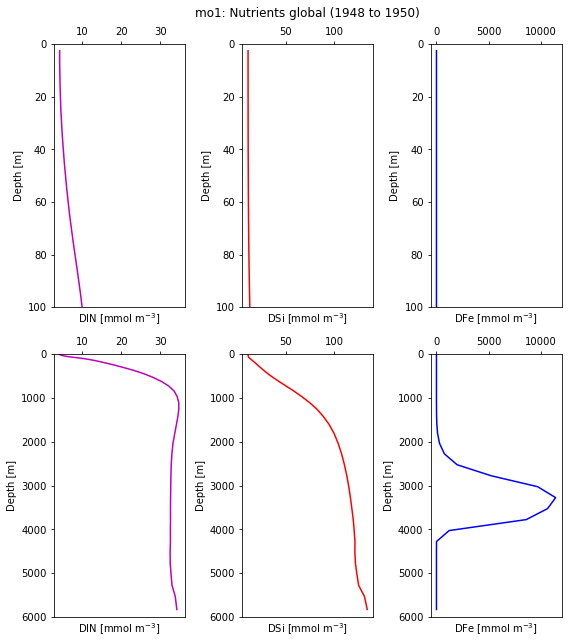

Plotting transect at lat -80 to 80, lon -25 to -25


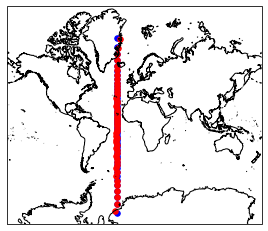

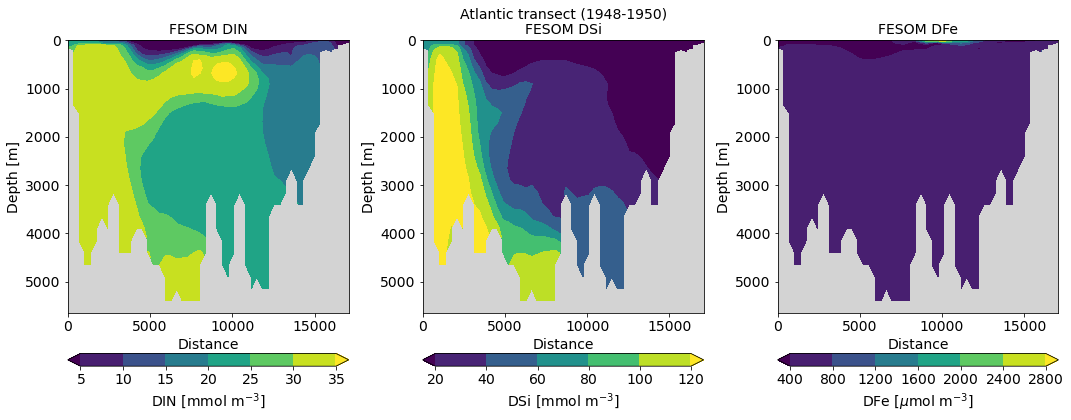

In [10]:
### TESTING ###
if __name__ == "__main__":  
    
    # run specification -------------------------------------------------------------------------------------
    runid      =  'mo1'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # period of analysis ------------------------------------------------------------------------------------
    first_year = 1948
    last_year  = 1950
    latmin, latmax = -60, 60
    latminmax = [latmin, latmax]
        

    # now test:
    test = Nut_depth(runid,resultpath,savepath,meshpath,obspath,first_year,last_year,
                     #latminmax=latminmax,
                     savefig=False)

### previous version
# process data ------------------------------------------------------------------------------
        # mean over years of sum(tracer * vol) / sum(vol)
        dinm = np.zeros(len(mesh.zlev)-1)
        dsim = np.zeros(len(mesh.zlev)-1)
        dfem = np.zeros(len(mesh.zlev)-1)
        dino = np.zeros(len(mesh.zlev)-1)
        dsio = np.zeros(len(mesh.zlev)-1)
        dfeo = np.zeros(len(mesh.zlev)-1)
        
        i_lat1 = np.greater_equal(mesh.y2, latmin)
        i_lat2 = np.less_equal(mesh.y2, latmax)
        i_lat = i_lat1*i_lat2
            
        for k in range(0,len(mesh.zlev)-2): #45
            #print('process depth '+str(mesh.zlev[k]))
            i_depth = np.where(mesh.zlev == mesh.zlev[k])
            
            nod_vol_aux = np.squeeze(nod_vol[i_lat,i_depth])
                        
            fesomDIN_aux = np.squeeze(fesomDIN[i_lat,i_depth])
            fesomDSi_aux = np.squeeze(fesomDSi[i_lat,i_depth])
            fesomDFe_aux = np.squeeze(fesomDFe[i_lat,i_depth])
            
            dinm[k] = np.sum(fesomDIN_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            dsim[k] = np.sum(fesomDSi_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            dfem[k] = np.sum(fesomDFe_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            
            if False:
                obsDIN_aux = np.squeeze(obsDIN[i_lat,i_depth])
                obsDSi_aux = np.squeeze(obsDSi[i_lat,i_depth])
                obsDFe_aux = np.squeeze(obsDFe[i_lat,i_depth])

                dino[k] = np.sum(obsDIN_aux*nod_vol_aux)/np.sum(nod_vol_aux)
                dsio[k] = np.sum(obsDSi_aux*nod_vol_aux)/np.sum(nod_vol_aux)
                dfeo[k] = np.sum(obsDFe_aux*nod_vol_aux)/np.sum(nod_vol_aux)
            
        # plot data ------------------------------------------------------------------------------            
        print('Plot at level depth (zlev) instead of layer depth. Better change to layer depth as scalars are defined there!??')
        fig = plt.figure(num=100, figsize=(8, 9), facecolor='w', edgecolor='k')
     
        plt.subplot(231)
        plt.plot(dinm,depths,'m-')
        #plt.plot(dino,depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0, 30)
        plt.xlabel(unitsDIN)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        plt.subplot(232)
        plt.plot(dsim,depths,'r-')
        #plt.plot(dsio,depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0, 60)
        plt.xlabel(unitsDSi)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        if(latminmax == [-90,90]):
            plt.title(self.runname+': Nutrients global ('+str(years[0])+' to '+str(years[len(years)-1])+')',y=1.08)
        else:
            latrange = 'Latitude from {0} to {1}'.format(latmin,latmax)
            plt.title(self.runname+': Nutrients ('+str(years[0])+' to '+str(years[len(years)-1])+')\n'+latrange,y=1.08)

        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off

        plt.subplot(233)
        plt.plot(dfem,depths,'b-')
        #plt.plot(dfeo,depths,'k*')
        plt.ylim(0,100)
        #plt.xlim(0,1)
        plt.xlabel(unitsDFe)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off
        
        plt.subplot(234)
        plt.plot(dinm,depths,'m-')
        #plt.plot(dino,depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0, 40)
        plt.xlabel(unitsDIN)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        plt.subplot(235)
        plt.plot(dsim,depths,'r-')
        #plt.plot(dsio,depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0, 136)
        plt.xlabel(unitsDSi)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off

        plt.subplot(236)
        plt.plot(dfem,depths,'b-')
        #plt.plot(dfeo,depths,'k*')
        plt.ylim(0,6000)
        #plt.xlim(0,1000)
        plt.xlabel(unitsDFe)
        plt.ylabel('Depth [m]')
        ax = plt.gca()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        #plt.tick_params(
            #axis='y',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            #right=False,      # ticks along the bottom edge are off
            #left=False,         # ticks along the top edge are off
            #labelleft=False) # labels along the bottom edge are off
        
        
        plt.tight_layout(h_pad=1.0)
        
        if self.savefig:
            plt.savefig(self.savepath+self.runname+'Nutrients_global'+'_'+str(years[0])+'to'+str(years[-1])+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)
            
            
        # Atlantic transect ------------------------------------------------------------------------------
        lon_start = -25
        lat_start = -80
        lon_end = -25
        lat_end = 80
        npoints   = 50
        lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

        print('Plotting transect at lat {0} to {1}, lon {2} to {3}'.format(lat_start,lat_end,lon_start,lon_end))
        pf.plot_transect_map(lonlat, mesh)

        dist, tfDIN = pf.get_transect(fesomDIN,mesh,lonlat)
        dist, tfDSi = pf.get_transect(fesomDSi,mesh,lonlat)
        dist, tfDFe = pf.get_transect(fesomDFe,mesh,lonlat)

        pf.plot_xyz(mesh, 
                    [tfDIN,tfDSi,tfDFe*1000],
                    dist,
                    maxdepth=6000,
                    ncols=3,
                    xlabel='Distance',
                    label=['DIN [mmol m$^{-3}$]', 'DSi [mmol m$^{-3}$]', 'DFe [$\mu$mol m$^{-3}$]'],
                    title=['FESOM DIN','Atlantic transect ({0}-{1})\nFESOM DSi'.format(first_year, last_year),'FESOM DFe'],
                    #levels=np.linspace(-2,2, 41),
                    cmap='viridis',
                    figsize=(15, 6))
        
        if self.savefig:
            plt.savefig(self.savepath+self.runname+'Nutrients_Atl_transect'+'_'+str(years[0])+'to'+str(years[-1])+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)